In [1]:
import pickle
import pandas as pd
import copy
import numpy as np
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import scipy.io
import tensorflow as tf
from utils import *

c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
with open('basket_data.pkl', 'rb') as file:
    save_dict = pickle.load(file)
all_vecs = scipy.io.loadmat('all_vecs.mat')
players_df = pd.DataFrame(save_dict['player_games'])
players_df = pd.read_pickle('players_df')
games_df = pd.read_pickle('games_df')
winner_df = pd.read_pickle('winner_games.pkl')
winner_df = pd.DataFrame(winner_df)
org_games = save_dict['games']

# See Solution #2 - Creating data notebook for creation of games_dict, training_mat and total_delta
with open('games_dict_for_sol2.pkl', 'rb') as file:
    games_dict = pickle.load(file)
    
total_training_mat = np.load('total_training_mat_sol2.npy')
total_training_mat = total_training_mat[:, :85, :, :]

total_delta_mat = np.load('total_delta_mat_sol2.npy')

# Creating Home/Away matrices:

In [ ]:
total_home_pts = np.zeros(total_delta_mat.shape)
total_away_pts = np.zeros(total_delta_mat.shape)

for k in range(len(total_training_mat)):
    pts_vec_home = total_training_mat[k, 0, 20, :13]
    pts_vec_away = total_training_mat[k, 0, 20, 13:]
    total_pts_diff = np.sum(pts_vec_home) - np.sum(pts_vec_away)
    #total_training_mat[k, 0, 54, 25] = total_pts_diff
    total_delta_mat[k] = total_pts_diff
    total_home_pts[k] = np.sum(pts_vec_home)
    total_away_pts[k] = np.sum(pts_vec_away)


total_num_players_mat1 = np.zeros((len(total_training_mat), 2))
total_num_players_mat2 = np.zeros((len(total_training_mat), 2))
for k in range(len(total_training_mat)):
    train_line_home = total_training_mat[k, 0, 54, :13]
    train_line_away = total_training_mat[k, 0, 54, 13:]
    total_num_players_mat1[k, 0] = 1.0/len(train_line_home[train_line_home == 1])
    total_num_players_mat1[k, 1] = 1.0/len(train_line_away[train_line_away == 1])
    total_num_players_mat2[k, 0] = len(train_line_home[train_line_home == 1])
    total_num_players_mat2[k, 1] = len(train_line_away[train_line_away == 1])
    
total_training_mat = total_training_mat[:, 1:, :, :]
max_hist_col = 0
for k in tqdm(range(len(total_training_mat))):
    for j in range(26):
        cur_vec = total_training_mat[k, :, :, j]
        content = cur_vec[cur_vec[:, 54] == 1, :]
        template = np.zeros((84, 55))
        if len(content) > max_hist_col:
            max_hist_col = len(content)
        for i in range(len(template)):
            if i >= len(content):
                break
            template[i, :] = content[i]

        total_training_mat[k, :, :, j] = template

total_training_mat = total_training_mat[:, :max_hist_col, :, :]


away_mat = total_training_mat[:, :, :, 13:]
home_mat = total_training_mat[:, :, :, :13]
away_mat_players_num_coeff = total_num_players_mat1[:, 1]
home_mat_players_num_coeff = total_num_players_mat1[:, 0]
away_mat_players_num = total_num_players_mat2[:, 1]
home_mat_players_num = total_num_players_mat2[:, 0]

# Preprocess:

In [2]:
idx = int(np.floor(len(total_training_mat)*0.8))
train_home_mat = home_mat[0:idx]
train_away_mat = away_mat[0:idx]
train_delta = total_delta_mat[0:idx]
train_home_pts = total_home_pts[0:idx]
train_away_pts = total_away_pts[0:idx]
train_home_mat_players_num_coeff = home_mat_players_num_coeff[0:idx]
train_away_mat_players_num_coeff = away_mat_players_num_coeff[0:idx]
train_home_mat_players_num = home_mat_players_num[0:idx]
train_away_mat_players_num = away_mat_players_num[0:idx]

val_home_mat = home_mat[idx:len(total_training_mat)]
val_away_mat = away_mat[idx:len(total_training_mat)]
val_delta = total_delta_mat[idx:len(total_training_mat)]
val_home_pts = total_home_pts[idx:len(total_training_mat)]
val_away_pts = total_away_pts[idx:len(total_training_mat)]
val_home_mat_players_num_coeff = home_mat_players_num_coeff[idx:len(total_training_mat)]
val_away_mat_players_num_coeff = away_mat_players_num_coeff[idx:len(total_training_mat)]
val_home_mat_players_num = home_mat_players_num[idx:len(total_training_mat)]
val_away_mat_players_num = away_mat_players_num[idx:len(total_training_mat)]

train_home_mat, saved_cols_home, max_cols_home, min_cols_home = preprocess(train_home_mat)
train_away_mat, saved_cols_away, max_cols_away, min_cols_away = preprocess(train_away_mat)
val_home_mat = preprocess_by_stats(val_home_mat, saved_cols_home, max_cols_home, min_cols_home)
val_away_mat = preprocess_by_stats(val_away_mat, saved_cols_away, max_cols_away, min_cols_away)

train_home_mat = train_home_mat[:, :, [20, 54], :]
val_home_mat = val_home_mat[:, :, [20,54], :]
train_away_mat = train_away_mat[:, :, [20, 54], :]
val_away_mat = val_away_mat[:, :, [20,54], :]

#keeping only last 15 games in history instead of entire history for now
train_home_mat = train_home_mat[:, :15, : ,:]
val_home_mat = val_home_mat[:, :15, :, :]
train_away_mat = train_away_mat[:, :15, : ,:]
val_away_mat = val_away_mat[:, :15, :, :]



In [4]:
train_home_5 = (np.where(train_home_mat_players_num == 5))
train_away_5 = (np.where(train_away_mat_players_num == 5))
train_home_6 = (np.where(train_home_mat_players_num == 6))
train_away_6 = (np.where(train_away_mat_players_num == 6))
train_home_7 = (np.where(train_home_mat_players_num == 7))
train_away_7 = (np.where(train_away_mat_players_num == 7))
train_home_8 = (np.where(train_home_mat_players_num == 8))
train_away_8 = (np.where(train_away_mat_players_num == 8))
train_home_9 = (np.where(train_home_mat_players_num == 9))
train_away_9 = (np.where(train_away_mat_players_num == 9))
train_home_10 = (np.where(train_home_mat_players_num == 10))
train_away_10 = (np.where(train_away_mat_players_num == 10))
train_home_11 = (np.where(train_home_mat_players_num == 11))
train_away_11 = (np.where(train_away_mat_players_num == 11))
train_home_12 = (np.where(train_home_mat_players_num == 12))
train_away_12 = (np.where(train_away_mat_players_num == 12))
train_home_13 = (np.where(train_home_mat_players_num == 13))
train_away_13 = (np.where(train_away_mat_players_num == 13))

val_home_5 = (np.where(val_home_mat_players_num == 5))
val_away_5 = (np.where(val_away_mat_players_num == 5))
val_home_6 = (np.where(val_home_mat_players_num == 6))
val_away_6 = (np.where(val_away_mat_players_num == 6))
val_home_7 = (np.where(val_home_mat_players_num == 7))
val_away_7 = (np.where(val_away_mat_players_num == 7))
val_home_8 = (np.where(val_home_mat_players_num == 8))
val_away_8 = (np.where(val_away_mat_players_num == 8))
val_home_9 = (np.where(val_home_mat_players_num == 9))
val_away_9 = (np.where(val_away_mat_players_num == 9))
val_home_10 = (np.where(val_home_mat_players_num == 10))
val_away_10 = (np.where(val_away_mat_players_num == 10))
val_home_11 = (np.where(val_home_mat_players_num == 11))
val_away_11 = (np.where(val_away_mat_players_num == 11))
val_home_12 = (np.where(val_home_mat_players_num == 12))
val_away_12 = (np.where(val_away_mat_players_num == 12))
val_home_13 = (np.where(val_home_mat_players_num == 13))
val_away_13 = (np.where(val_away_mat_players_num == 13))

train_home_list = [train_home_5, train_home_6, train_home_7, train_home_8, train_home_9, train_home_10, train_home_11,
                    train_home_12, train_home_13]
train_away_list = [train_away_5, train_away_6, train_away_7, train_away_8, train_away_9, train_away_10, train_away_11,
                    train_away_12, train_away_13]

val_home_list = [val_home_5, val_home_6, val_home_7, val_home_8, val_home_9, val_home_10, val_home_11,
                    train_home_12, train_home_13]
val_away_list = [val_away_5, val_away_6, val_away_7, val_away_8, val_away_9, val_away_10, val_away_11,
                    val_away_12, val_away_13]

In [55]:
model = get_model(train_home_mat.shape[1:], train_home_list, train_away_list, val_home_list, val_away_list)

model.summary()

AttributeError: 'NoneType' object has no attribute '_inbound_nodes'

In [12]:
history = model.fit([train_home_mat, train_away_mat, train_home_mat_players_num_coeff,\
                    train_away_mat_players_num_coeff, 1],\
                    [train_home_pts, train_away_pts, train_delta], 
                    batch_size=256, epochs=3000, verbose=2, shuffle=True, 
                    validation_data=([val_home_mat, val_away_mat, val_home_mat_players_num_coeff,\
                                      val_away_mat_players_num_coeff, 0],\
                                     [val_home_pts, val_away_pts, val_delta]),
                    callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=200)])

Instructions for updating:
Use tf.cast instead.
Train on 2721 samples, validate on 681 samples
Epoch 1/3000
 - 5s - loss: 13940.1845 - home_pts_loss: 7096.5505 - away_pts_loss: 6590.9199 - diff_pts_loss: 252.7141 - diff_pts_mean_absolute_error: 12.1591 - val_loss: 13659.5562 - val_home_pts_loss: 6946.8396 - val_away_pts_loss: 6526.5979 - val_diff_pts_loss: 186.1184 - val_diff_pts_mean_absolute_error: 10.7935
Epoch 2/3000
 - 0s - loss: 13679.0804 - home_pts_loss: 6963.1499 - away_pts_loss: 6464.9670 - diff_pts_loss: 250.9633 - diff_pts_mean_absolute_error: 12.0999 - val_loss: 13366.1628 - val_home_pts_loss: 6798.8265 - val_away_pts_loss: 6383.2518 - val_diff_pts_loss: 184.0847 - val_diff_pts_mean_absolute_error: 10.7184
Epoch 3/3000
 - 0s - loss: 13297.0590 - home_pts_loss: 6763.7351 - away_pts_loss: 6284.8960 - diff_pts_loss: 248.4279 - diff_pts_mean_absolute_error: 12.0019 - val_loss: 12865.7412 - val_home_pts_loss: 6541.6705 - val_away_pts_loss: 6142.4339 - val_diff_pts_loss: 181.636

Epoch 27/3000
 - 0s - loss: 845.9046 - home_pts_loss: 313.3094 - away_pts_loss: 289.6211 - diff_pts_loss: 242.9741 - diff_pts_mean_absolute_error: 11.7987 - val_loss: 595.5454 - val_home_pts_loss: 201.7975 - val_away_pts_loss: 215.2329 - val_diff_pts_loss: 178.5150 - val_diff_pts_mean_absolute_error: 10.5178
Epoch 28/3000
 - 0s - loss: 844.9101 - home_pts_loss: 313.4227 - away_pts_loss: 288.4833 - diff_pts_loss: 243.0041 - diff_pts_mean_absolute_error: 11.8042 - val_loss: 591.4184 - val_home_pts_loss: 200.2953 - val_away_pts_loss: 212.2441 - val_diff_pts_loss: 178.8790 - val_diff_pts_mean_absolute_error: 10.5298
Epoch 29/3000
 - 0s - loss: 840.4277 - home_pts_loss: 312.7605 - away_pts_loss: 284.1554 - diff_pts_loss: 243.5119 - diff_pts_mean_absolute_error: 11.7687 - val_loss: 594.8787 - val_home_pts_loss: 201.5510 - val_away_pts_loss: 214.2042 - val_diff_pts_loss: 179.1236 - val_diff_pts_mean_absolute_error: 10.5408
Epoch 30/3000
 - 0s - loss: 833.2291 - home_pts_loss: 310.1092 - away_

Epoch 54/3000
 - 0s - loss: 794.6575 - home_pts_loss: 296.1068 - away_pts_loss: 258.7111 - diff_pts_loss: 239.8396 - diff_pts_mean_absolute_error: 11.7172 - val_loss: 592.4906 - val_home_pts_loss: 204.0317 - val_away_pts_loss: 215.0744 - val_diff_pts_loss: 173.3845 - val_diff_pts_mean_absolute_error: 10.3825
Epoch 55/3000
 - 0s - loss: 795.3674 - home_pts_loss: 296.8062 - away_pts_loss: 260.0661 - diff_pts_loss: 238.4951 - diff_pts_mean_absolute_error: 11.6985 - val_loss: 604.2602 - val_home_pts_loss: 209.4129 - val_away_pts_loss: 222.0113 - val_diff_pts_loss: 172.8360 - val_diff_pts_mean_absolute_error: 10.3529
Epoch 56/3000
 - 0s - loss: 797.2994 - home_pts_loss: 296.5331 - away_pts_loss: 261.5847 - diff_pts_loss: 239.1817 - diff_pts_mean_absolute_error: 11.6993 - val_loss: 588.4286 - val_home_pts_loss: 203.5724 - val_away_pts_loss: 212.7257 - val_diff_pts_loss: 172.1305 - val_diff_pts_mean_absolute_error: 10.3412
Epoch 57/3000
 - 0s - loss: 799.7869 - home_pts_loss: 300.1386 - away_

Epoch 81/3000
 - 0s - loss: 787.8402 - home_pts_loss: 295.8702 - away_pts_loss: 255.3751 - diff_pts_loss: 236.5950 - diff_pts_mean_absolute_error: 11.6786 - val_loss: 596.1641 - val_home_pts_loss: 208.5317 - val_away_pts_loss: 220.8752 - val_diff_pts_loss: 166.7572 - val_diff_pts_mean_absolute_error: 10.2143
Epoch 82/3000
 - 0s - loss: 785.5992 - home_pts_loss: 291.9615 - away_pts_loss: 257.3689 - diff_pts_loss: 236.2688 - diff_pts_mean_absolute_error: 11.6495 - val_loss: 597.2759 - val_home_pts_loss: 210.5723 - val_away_pts_loss: 219.9200 - val_diff_pts_loss: 166.7836 - val_diff_pts_mean_absolute_error: 10.2115
Epoch 83/3000
 - 0s - loss: 787.8952 - home_pts_loss: 294.5164 - away_pts_loss: 257.8840 - diff_pts_loss: 235.4948 - diff_pts_mean_absolute_error: 11.6608 - val_loss: 595.8411 - val_home_pts_loss: 208.4974 - val_away_pts_loss: 220.8017 - val_diff_pts_loss: 166.5420 - val_diff_pts_mean_absolute_error: 10.2111
Epoch 84/3000
 - 0s - loss: 787.4404 - home_pts_loss: 293.1077 - away_

Epoch 108/3000
 - 0s - loss: 778.7928 - home_pts_loss: 290.9106 - away_pts_loss: 254.4869 - diff_pts_loss: 233.3952 - diff_pts_mean_absolute_error: 11.6009 - val_loss: 606.1318 - val_home_pts_loss: 215.9165 - val_away_pts_loss: 224.4272 - val_diff_pts_loss: 165.7881 - val_diff_pts_mean_absolute_error: 10.1864
Epoch 109/3000
 - 0s - loss: 780.1843 - home_pts_loss: 291.0135 - away_pts_loss: 255.4158 - diff_pts_loss: 233.7549 - diff_pts_mean_absolute_error: 11.6319 - val_loss: 581.0107 - val_home_pts_loss: 203.3913 - val_away_pts_loss: 212.6999 - val_diff_pts_loss: 164.9195 - val_diff_pts_mean_absolute_error: 10.1712
Epoch 110/3000
 - 0s - loss: 781.0900 - home_pts_loss: 292.4445 - away_pts_loss: 253.8212 - diff_pts_loss: 234.8242 - diff_pts_mean_absolute_error: 11.6530 - val_loss: 607.3668 - val_home_pts_loss: 211.9690 - val_away_pts_loss: 230.5435 - val_diff_pts_loss: 164.8543 - val_diff_pts_mean_absolute_error: 10.1691
Epoch 111/3000
 - 0s - loss: 779.6319 - home_pts_loss: 289.7883 - a

Epoch 135/3000
 - 0s - loss: 771.8809 - home_pts_loss: 288.7738 - away_pts_loss: 253.1307 - diff_pts_loss: 229.9764 - diff_pts_mean_absolute_error: 11.5455 - val_loss: 603.8280 - val_home_pts_loss: 207.6368 - val_away_pts_loss: 232.4523 - val_diff_pts_loss: 163.7389 - val_diff_pts_mean_absolute_error: 10.1330
Epoch 136/3000
 - 0s - loss: 770.8026 - home_pts_loss: 289.7288 - away_pts_loss: 251.0149 - diff_pts_loss: 230.0589 - diff_pts_mean_absolute_error: 11.5780 - val_loss: 579.6330 - val_home_pts_loss: 201.7452 - val_away_pts_loss: 214.2401 - val_diff_pts_loss: 163.6476 - val_diff_pts_mean_absolute_error: 10.1265
Epoch 137/3000
 - 0s - loss: 772.3092 - home_pts_loss: 286.3436 - away_pts_loss: 254.5199 - diff_pts_loss: 231.4456 - diff_pts_mean_absolute_error: 11.5890 - val_loss: 592.6928 - val_home_pts_loss: 204.4029 - val_away_pts_loss: 225.0525 - val_diff_pts_loss: 163.2374 - val_diff_pts_mean_absolute_error: 10.1218
Epoch 138/3000
 - 0s - loss: 770.8708 - home_pts_loss: 285.6282 - a

Epoch 162/3000
 - 0s - loss: 773.0039 - home_pts_loss: 287.3729 - away_pts_loss: 253.1189 - diff_pts_loss: 232.5121 - diff_pts_mean_absolute_error: 11.6074 - val_loss: 585.9219 - val_home_pts_loss: 195.7410 - val_away_pts_loss: 225.2789 - val_diff_pts_loss: 164.9020 - val_diff_pts_mean_absolute_error: 10.1687
Epoch 163/3000
 - 0s - loss: 764.4087 - home_pts_loss: 285.0839 - away_pts_loss: 250.0442 - diff_pts_loss: 229.2806 - diff_pts_mean_absolute_error: 11.5572 - val_loss: 575.2095 - val_home_pts_loss: 200.2412 - val_away_pts_loss: 210.5519 - val_diff_pts_loss: 164.4164 - val_diff_pts_mean_absolute_error: 10.1378
Epoch 164/3000
 - 0s - loss: 773.3157 - home_pts_loss: 290.7303 - away_pts_loss: 251.7019 - diff_pts_loss: 230.8835 - diff_pts_mean_absolute_error: 11.5454 - val_loss: 577.1072 - val_home_pts_loss: 203.9581 - val_away_pts_loss: 209.8668 - val_diff_pts_loss: 163.2823 - val_diff_pts_mean_absolute_error: 10.1147
Epoch 165/3000
 - 0s - loss: 769.6101 - home_pts_loss: 287.3263 - a

Epoch 189/3000
 - 0s - loss: 767.7312 - home_pts_loss: 287.8529 - away_pts_loss: 250.2114 - diff_pts_loss: 229.6669 - diff_pts_mean_absolute_error: 11.5585 - val_loss: 559.7181 - val_home_pts_loss: 192.8629 - val_away_pts_loss: 203.8974 - val_diff_pts_loss: 162.9578 - val_diff_pts_mean_absolute_error: 10.0977
Epoch 190/3000
 - 0s - loss: 765.8156 - home_pts_loss: 288.4100 - away_pts_loss: 247.9682 - diff_pts_loss: 229.4374 - diff_pts_mean_absolute_error: 11.5312 - val_loss: 564.4127 - val_home_pts_loss: 189.8736 - val_away_pts_loss: 211.7849 - val_diff_pts_loss: 162.7542 - val_diff_pts_mean_absolute_error: 10.0946
Epoch 191/3000
 - 0s - loss: 767.1737 - home_pts_loss: 285.4700 - away_pts_loss: 250.7705 - diff_pts_loss: 230.9331 - diff_pts_mean_absolute_error: 11.5865 - val_loss: 559.8714 - val_home_pts_loss: 192.6077 - val_away_pts_loss: 204.2797 - val_diff_pts_loss: 162.9840 - val_diff_pts_mean_absolute_error: 10.0960
Epoch 192/3000
 - 0s - loss: 763.1196 - home_pts_loss: 284.7715 - a

Epoch 216/3000
 - 0s - loss: 761.0753 - home_pts_loss: 283.0318 - away_pts_loss: 249.8377 - diff_pts_loss: 228.2058 - diff_pts_mean_absolute_error: 11.4905 - val_loss: 561.0481 - val_home_pts_loss: 191.6595 - val_away_pts_loss: 206.8637 - val_diff_pts_loss: 162.5249 - val_diff_pts_mean_absolute_error: 10.0850
Epoch 217/3000
 - 0s - loss: 759.3906 - home_pts_loss: 282.8181 - away_pts_loss: 246.7496 - diff_pts_loss: 229.8229 - diff_pts_mean_absolute_error: 11.5798 - val_loss: 560.6523 - val_home_pts_loss: 190.0020 - val_away_pts_loss: 207.9851 - val_diff_pts_loss: 162.6652 - val_diff_pts_mean_absolute_error: 10.0853
Epoch 218/3000
 - 0s - loss: 761.4514 - home_pts_loss: 284.6075 - away_pts_loss: 251.4652 - diff_pts_loss: 225.3786 - diff_pts_mean_absolute_error: 11.4518 - val_loss: 555.3556 - val_home_pts_loss: 186.7964 - val_away_pts_loss: 206.0980 - val_diff_pts_loss: 162.4612 - val_diff_pts_mean_absolute_error: 10.0799
Epoch 219/3000
 - 0s - loss: 759.9177 - home_pts_loss: 280.5814 - a

Epoch 243/3000
 - 0s - loss: 757.1131 - home_pts_loss: 281.7501 - away_pts_loss: 246.8891 - diff_pts_loss: 228.4739 - diff_pts_mean_absolute_error: 11.5086 - val_loss: 571.5832 - val_home_pts_loss: 199.1893 - val_away_pts_loss: 209.4464 - val_diff_pts_loss: 162.9474 - val_diff_pts_mean_absolute_error: 10.0774
Epoch 244/3000
 - 0s - loss: 759.4372 - home_pts_loss: 282.6605 - away_pts_loss: 248.6176 - diff_pts_loss: 228.1591 - diff_pts_mean_absolute_error: 11.5380 - val_loss: 574.3333 - val_home_pts_loss: 201.4161 - val_away_pts_loss: 210.1510 - val_diff_pts_loss: 162.7663 - val_diff_pts_mean_absolute_error: 10.0759
Epoch 245/3000
 - 0s - loss: 754.5886 - home_pts_loss: 281.3144 - away_pts_loss: 247.0674 - diff_pts_loss: 226.2067 - diff_pts_mean_absolute_error: 11.4438 - val_loss: 553.0742 - val_home_pts_loss: 185.8402 - val_away_pts_loss: 204.6919 - val_diff_pts_loss: 162.5421 - val_diff_pts_mean_absolute_error: 10.0737
Epoch 246/3000
 - 0s - loss: 756.9404 - home_pts_loss: 280.8468 - a

Epoch 270/3000
 - 0s - loss: 753.9608 - home_pts_loss: 282.1173 - away_pts_loss: 246.6589 - diff_pts_loss: 225.1845 - diff_pts_mean_absolute_error: 11.4612 - val_loss: 575.7655 - val_home_pts_loss: 196.8929 - val_away_pts_loss: 216.7901 - val_diff_pts_loss: 162.0825 - val_diff_pts_mean_absolute_error: 10.0634
Epoch 271/3000
 - 0s - loss: 749.5937 - home_pts_loss: 279.0950 - away_pts_loss: 245.1668 - diff_pts_loss: 225.3318 - diff_pts_mean_absolute_error: 11.4582 - val_loss: 551.5389 - val_home_pts_loss: 185.6229 - val_away_pts_loss: 203.6959 - val_diff_pts_loss: 162.2200 - val_diff_pts_mean_absolute_error: 10.0611
Epoch 272/3000
 - 0s - loss: 751.9145 - home_pts_loss: 280.1627 - away_pts_loss: 246.7972 - diff_pts_loss: 224.9546 - diff_pts_mean_absolute_error: 11.4199 - val_loss: 571.2908 - val_home_pts_loss: 194.4031 - val_away_pts_loss: 214.6636 - val_diff_pts_loss: 162.2240 - val_diff_pts_mean_absolute_error: 10.0684
Epoch 273/3000
 - 0s - loss: 747.7651 - home_pts_loss: 276.7410 - a

Epoch 297/3000
 - 0s - loss: 752.7622 - home_pts_loss: 280.1705 - away_pts_loss: 248.0867 - diff_pts_loss: 224.5050 - diff_pts_mean_absolute_error: 11.4434 - val_loss: 565.3601 - val_home_pts_loss: 192.4179 - val_away_pts_loss: 210.3516 - val_diff_pts_loss: 162.5906 - val_diff_pts_mean_absolute_error: 10.0751
Epoch 298/3000
 - 0s - loss: 747.8613 - home_pts_loss: 277.8720 - away_pts_loss: 245.1587 - diff_pts_loss: 224.8306 - diff_pts_mean_absolute_error: 11.4920 - val_loss: 548.8796 - val_home_pts_loss: 182.9928 - val_away_pts_loss: 203.2486 - val_diff_pts_loss: 162.6382 - val_diff_pts_mean_absolute_error: 10.0725
Epoch 299/3000
 - 0s - loss: 750.7078 - home_pts_loss: 276.5095 - away_pts_loss: 248.8668 - diff_pts_loss: 225.3315 - diff_pts_mean_absolute_error: 11.4308 - val_loss: 555.8821 - val_home_pts_loss: 188.4248 - val_away_pts_loss: 203.1929 - val_diff_pts_loss: 164.2643 - val_diff_pts_mean_absolute_error: 10.0978
Epoch 300/3000
 - 0s - loss: 747.6652 - home_pts_loss: 279.6000 - a

Epoch 324/3000
 - 0s - loss: 744.0915 - home_pts_loss: 276.6617 - away_pts_loss: 243.5491 - diff_pts_loss: 223.8807 - diff_pts_mean_absolute_error: 11.4499 - val_loss: 550.8123 - val_home_pts_loss: 184.8177 - val_away_pts_loss: 203.1936 - val_diff_pts_loss: 162.8011 - val_diff_pts_mean_absolute_error: 10.0682
Epoch 325/3000
 - 0s - loss: 740.0978 - home_pts_loss: 272.4254 - away_pts_loss: 245.5475 - diff_pts_loss: 222.1249 - diff_pts_mean_absolute_error: 11.4204 - val_loss: 576.4667 - val_home_pts_loss: 196.4251 - val_away_pts_loss: 217.0279 - val_diff_pts_loss: 163.0137 - val_diff_pts_mean_absolute_error: 10.0740
Epoch 326/3000
 - 0s - loss: 743.1091 - home_pts_loss: 276.8253 - away_pts_loss: 244.6949 - diff_pts_loss: 221.5889 - diff_pts_mean_absolute_error: 11.4363 - val_loss: 557.4569 - val_home_pts_loss: 188.0434 - val_away_pts_loss: 207.1405 - val_diff_pts_loss: 162.2730 - val_diff_pts_mean_absolute_error: 10.0670
Epoch 327/3000
 - 0s - loss: 740.0181 - home_pts_loss: 273.1829 - a

Epoch 351/3000
 - 0s - loss: 740.1687 - home_pts_loss: 272.1111 - away_pts_loss: 241.9488 - diff_pts_loss: 226.1088 - diff_pts_mean_absolute_error: 11.4758 - val_loss: 560.6403 - val_home_pts_loss: 191.1150 - val_away_pts_loss: 206.3398 - val_diff_pts_loss: 163.1855 - val_diff_pts_mean_absolute_error: 10.0734
Epoch 352/3000
 - 0s - loss: 744.1000 - home_pts_loss: 276.0457 - away_pts_loss: 243.8609 - diff_pts_loss: 224.1934 - diff_pts_mean_absolute_error: 11.4517 - val_loss: 556.8374 - val_home_pts_loss: 189.6818 - val_away_pts_loss: 203.8036 - val_diff_pts_loss: 163.3519 - val_diff_pts_mean_absolute_error: 10.0840
Epoch 353/3000
 - 0s - loss: 742.6341 - home_pts_loss: 273.7617 - away_pts_loss: 244.3703 - diff_pts_loss: 224.5020 - diff_pts_mean_absolute_error: 11.4816 - val_loss: 555.1070 - val_home_pts_loss: 186.5346 - val_away_pts_loss: 205.8368 - val_diff_pts_loss: 162.7356 - val_diff_pts_mean_absolute_error: 10.0663
Epoch 354/3000
 - 0s - loss: 739.6596 - home_pts_loss: 274.6226 - a

Epoch 378/3000
 - 0s - loss: 733.0668 - home_pts_loss: 270.3865 - away_pts_loss: 242.2296 - diff_pts_loss: 220.4507 - diff_pts_mean_absolute_error: 11.3489 - val_loss: 559.4073 - val_home_pts_loss: 188.6133 - val_away_pts_loss: 207.9338 - val_diff_pts_loss: 162.8601 - val_diff_pts_mean_absolute_error: 10.0720
Epoch 379/3000
 - 0s - loss: 734.1142 - home_pts_loss: 268.5478 - away_pts_loss: 242.0003 - diff_pts_loss: 223.5661 - diff_pts_mean_absolute_error: 11.3795 - val_loss: 551.1618 - val_home_pts_loss: 187.2176 - val_away_pts_loss: 201.2553 - val_diff_pts_loss: 162.6888 - val_diff_pts_mean_absolute_error: 10.0675
Epoch 380/3000
 - 0s - loss: 733.6075 - home_pts_loss: 268.9548 - away_pts_loss: 243.0036 - diff_pts_loss: 221.6491 - diff_pts_mean_absolute_error: 11.4132 - val_loss: 537.6751 - val_home_pts_loss: 178.1684 - val_away_pts_loss: 196.5388 - val_diff_pts_loss: 162.9679 - val_diff_pts_mean_absolute_error: 10.0701
Epoch 381/3000
 - 0s - loss: 736.0550 - home_pts_loss: 269.8260 - a

Epoch 405/3000
 - 0s - loss: 730.4358 - home_pts_loss: 266.5774 - away_pts_loss: 242.3523 - diff_pts_loss: 221.5061 - diff_pts_mean_absolute_error: 11.3879 - val_loss: 549.7488 - val_home_pts_loss: 185.2800 - val_away_pts_loss: 201.8089 - val_diff_pts_loss: 162.6599 - val_diff_pts_mean_absolute_error: 10.0586
Epoch 406/3000
 - 0s - loss: 732.5348 - home_pts_loss: 267.1186 - away_pts_loss: 241.8457 - diff_pts_loss: 223.5705 - diff_pts_mean_absolute_error: 11.3976 - val_loss: 544.4264 - val_home_pts_loss: 179.0523 - val_away_pts_loss: 202.8129 - val_diff_pts_loss: 162.5612 - val_diff_pts_mean_absolute_error: 10.0559
Epoch 407/3000
 - 0s - loss: 731.9606 - home_pts_loss: 266.9466 - away_pts_loss: 242.6419 - diff_pts_loss: 222.3722 - diff_pts_mean_absolute_error: 11.3771 - val_loss: 533.3265 - val_home_pts_loss: 170.1501 - val_away_pts_loss: 201.3946 - val_diff_pts_loss: 161.7818 - val_diff_pts_mean_absolute_error: 10.0461
Epoch 408/3000
 - 0s - loss: 728.9564 - home_pts_loss: 266.3785 - a

Epoch 432/3000
 - 0s - loss: 717.2246 - home_pts_loss: 258.0573 - away_pts_loss: 238.2919 - diff_pts_loss: 220.8754 - diff_pts_mean_absolute_error: 11.3793 - val_loss: 531.7097 - val_home_pts_loss: 172.7418 - val_away_pts_loss: 198.4286 - val_diff_pts_loss: 160.5393 - val_diff_pts_mean_absolute_error: 9.9961
Epoch 433/3000
 - 0s - loss: 720.1424 - home_pts_loss: 257.4462 - away_pts_loss: 241.5496 - diff_pts_loss: 221.1467 - diff_pts_mean_absolute_error: 11.3628 - val_loss: 530.4158 - val_home_pts_loss: 172.1614 - val_away_pts_loss: 197.6476 - val_diff_pts_loss: 160.6068 - val_diff_pts_mean_absolute_error: 10.0012
Epoch 434/3000
 - 0s - loss: 719.5067 - home_pts_loss: 258.6987 - away_pts_loss: 240.6997 - diff_pts_loss: 220.1084 - diff_pts_mean_absolute_error: 11.3489 - val_loss: 541.4190 - val_home_pts_loss: 178.5487 - val_away_pts_loss: 202.0556 - val_diff_pts_loss: 160.8146 - val_diff_pts_mean_absolute_error: 10.0038
Epoch 435/3000
 - 0s - loss: 711.8323 - home_pts_loss: 254.3777 - aw

Epoch 459/3000
 - 0s - loss: 700.0524 - home_pts_loss: 246.6309 - away_pts_loss: 240.0636 - diff_pts_loss: 213.3579 - diff_pts_mean_absolute_error: 11.2016 - val_loss: 527.7035 - val_home_pts_loss: 167.1620 - val_away_pts_loss: 203.4372 - val_diff_pts_loss: 157.1043 - val_diff_pts_mean_absolute_error: 9.8820
Epoch 460/3000
 - 0s - loss: 700.8101 - home_pts_loss: 243.2657 - away_pts_loss: 242.4122 - diff_pts_loss: 215.1322 - diff_pts_mean_absolute_error: 11.2081 - val_loss: 530.5767 - val_home_pts_loss: 166.7969 - val_away_pts_loss: 204.8719 - val_diff_pts_loss: 158.9079 - val_diff_pts_mean_absolute_error: 9.9178
Epoch 461/3000
 - 0s - loss: 697.8490 - home_pts_loss: 246.0336 - away_pts_loss: 237.4496 - diff_pts_loss: 214.3658 - diff_pts_mean_absolute_error: 11.1800 - val_loss: 535.8340 - val_home_pts_loss: 173.7675 - val_away_pts_loss: 204.7469 - val_diff_pts_loss: 157.3196 - val_diff_pts_mean_absolute_error: 9.8840
Epoch 462/3000
 - 0s - loss: 698.3269 - home_pts_loss: 243.2547 - away

Epoch 486/3000
 - 0s - loss: 669.4146 - home_pts_loss: 215.0494 - away_pts_loss: 238.6334 - diff_pts_loss: 215.7318 - diff_pts_mean_absolute_error: 11.1561 - val_loss: 498.5767 - val_home_pts_loss: 141.2188 - val_away_pts_loss: 201.5934 - val_diff_pts_loss: 155.7645 - val_diff_pts_mean_absolute_error: 9.7839
Epoch 487/3000
 - 0s - loss: 670.0008 - home_pts_loss: 216.4024 - away_pts_loss: 237.1927 - diff_pts_loss: 216.4057 - diff_pts_mean_absolute_error: 11.1624 - val_loss: 502.3398 - val_home_pts_loss: 142.7258 - val_away_pts_loss: 202.4987 - val_diff_pts_loss: 157.1153 - val_diff_pts_mean_absolute_error: 9.8105
Epoch 488/3000
 - 0s - loss: 662.3763 - home_pts_loss: 212.9911 - away_pts_loss: 236.2158 - diff_pts_loss: 213.1695 - diff_pts_mean_absolute_error: 11.1547 - val_loss: 500.7777 - val_home_pts_loss: 145.5636 - val_away_pts_loss: 199.2905 - val_diff_pts_loss: 155.9237 - val_diff_pts_mean_absolute_error: 9.7854
Epoch 489/3000
 - 0s - loss: 667.5186 - home_pts_loss: 217.5866 - away

Epoch 513/3000
 - 0s - loss: 653.5613 - home_pts_loss: 204.4117 - away_pts_loss: 235.6015 - diff_pts_loss: 213.5481 - diff_pts_mean_absolute_error: 11.0227 - val_loss: 492.9318 - val_home_pts_loss: 137.7864 - val_away_pts_loss: 200.3078 - val_diff_pts_loss: 154.8376 - val_diff_pts_mean_absolute_error: 9.7522
Epoch 514/3000
 - 0s - loss: 655.4421 - home_pts_loss: 207.1622 - away_pts_loss: 236.2118 - diff_pts_loss: 212.0681 - diff_pts_mean_absolute_error: 11.0800 - val_loss: 494.4640 - val_home_pts_loss: 141.2047 - val_away_pts_loss: 195.3962 - val_diff_pts_loss: 157.8631 - val_diff_pts_mean_absolute_error: 9.7886
Epoch 515/3000
 - 0s - loss: 650.5993 - home_pts_loss: 203.3387 - away_pts_loss: 234.8448 - diff_pts_loss: 212.4158 - diff_pts_mean_absolute_error: 11.0481 - val_loss: 494.5540 - val_home_pts_loss: 137.3823 - val_away_pts_loss: 202.2806 - val_diff_pts_loss: 154.8912 - val_diff_pts_mean_absolute_error: 9.7463
Epoch 516/3000
 - 0s - loss: 644.6954 - home_pts_loss: 201.9674 - away

Epoch 540/3000
 - 0s - loss: 650.0479 - home_pts_loss: 196.9204 - away_pts_loss: 239.2042 - diff_pts_loss: 213.9232 - diff_pts_mean_absolute_error: 11.0734 - val_loss: 499.1698 - val_home_pts_loss: 141.6548 - val_away_pts_loss: 201.1053 - val_diff_pts_loss: 156.4097 - val_diff_pts_mean_absolute_error: 9.7742
Epoch 541/3000
 - 0s - loss: 643.7495 - home_pts_loss: 197.7369 - away_pts_loss: 236.3758 - diff_pts_loss: 209.6367 - diff_pts_mean_absolute_error: 11.0042 - val_loss: 492.3818 - val_home_pts_loss: 137.5062 - val_away_pts_loss: 198.6355 - val_diff_pts_loss: 156.2400 - val_diff_pts_mean_absolute_error: 9.7556
Epoch 542/3000
 - 0s - loss: 644.7517 - home_pts_loss: 195.0658 - away_pts_loss: 235.0275 - diff_pts_loss: 214.6584 - diff_pts_mean_absolute_error: 11.0589 - val_loss: 480.5345 - val_home_pts_loss: 134.5836 - val_away_pts_loss: 188.5296 - val_diff_pts_loss: 157.4212 - val_diff_pts_mean_absolute_error: 9.7891
Epoch 543/3000
 - 0s - loss: 640.3780 - home_pts_loss: 194.9280 - away

Epoch 567/3000
 - 0s - loss: 634.5845 - home_pts_loss: 190.6287 - away_pts_loss: 232.5876 - diff_pts_loss: 211.3682 - diff_pts_mean_absolute_error: 10.9979 - val_loss: 483.5041 - val_home_pts_loss: 134.3715 - val_away_pts_loss: 192.9131 - val_diff_pts_loss: 156.2195 - val_diff_pts_mean_absolute_error: 9.7379
Epoch 568/3000
 - 0s - loss: 631.2798 - home_pts_loss: 192.7810 - away_pts_loss: 229.7745 - diff_pts_loss: 208.7242 - diff_pts_mean_absolute_error: 10.9102 - val_loss: 487.4592 - val_home_pts_loss: 136.6783 - val_away_pts_loss: 195.1328 - val_diff_pts_loss: 155.6480 - val_diff_pts_mean_absolute_error: 9.7391
Epoch 569/3000
 - 0s - loss: 634.3393 - home_pts_loss: 194.7297 - away_pts_loss: 230.6421 - diff_pts_loss: 208.9675 - diff_pts_mean_absolute_error: 10.9716 - val_loss: 489.8919 - val_home_pts_loss: 134.8326 - val_away_pts_loss: 200.5040 - val_diff_pts_loss: 154.5553 - val_diff_pts_mean_absolute_error: 9.7312
Epoch 570/3000
 - 0s - loss: 631.3166 - home_pts_loss: 188.7186 - away

Epoch 594/3000
 - 0s - loss: 629.5483 - home_pts_loss: 192.1491 - away_pts_loss: 231.1572 - diff_pts_loss: 206.2420 - diff_pts_mean_absolute_error: 10.8888 - val_loss: 477.7931 - val_home_pts_loss: 134.4397 - val_away_pts_loss: 188.7152 - val_diff_pts_loss: 154.6382 - val_diff_pts_mean_absolute_error: 9.7149
Epoch 595/3000
 - 0s - loss: 619.3677 - home_pts_loss: 185.9160 - away_pts_loss: 227.2485 - diff_pts_loss: 206.2033 - diff_pts_mean_absolute_error: 10.9089 - val_loss: 484.0918 - val_home_pts_loss: 135.3827 - val_away_pts_loss: 193.9336 - val_diff_pts_loss: 154.7755 - val_diff_pts_mean_absolute_error: 9.7199
Epoch 596/3000
 - 0s - loss: 623.2331 - home_pts_loss: 187.0187 - away_pts_loss: 228.0080 - diff_pts_loss: 208.2063 - diff_pts_mean_absolute_error: 10.8769 - val_loss: 483.5996 - val_home_pts_loss: 131.9162 - val_away_pts_loss: 197.9780 - val_diff_pts_loss: 153.7054 - val_diff_pts_mean_absolute_error: 9.7053
Epoch 597/3000
 - 0s - loss: 625.5192 - home_pts_loss: 189.4498 - away

Epoch 621/3000
 - 0s - loss: 622.5662 - home_pts_loss: 190.2061 - away_pts_loss: 223.4570 - diff_pts_loss: 208.9031 - diff_pts_mean_absolute_error: 10.8469 - val_loss: 472.5978 - val_home_pts_loss: 132.9993 - val_away_pts_loss: 185.8254 - val_diff_pts_loss: 153.7731 - val_diff_pts_mean_absolute_error: 9.6940
Epoch 622/3000
 - 0s - loss: 615.6103 - home_pts_loss: 184.7328 - away_pts_loss: 224.0647 - diff_pts_loss: 206.8127 - diff_pts_mean_absolute_error: 10.9481 - val_loss: 468.2652 - val_home_pts_loss: 132.3114 - val_away_pts_loss: 182.6993 - val_diff_pts_loss: 153.2545 - val_diff_pts_mean_absolute_error: 9.6738
Epoch 623/3000
 - 0s - loss: 616.5525 - home_pts_loss: 186.6766 - away_pts_loss: 222.7846 - diff_pts_loss: 207.0913 - diff_pts_mean_absolute_error: 10.8675 - val_loss: 468.1765 - val_home_pts_loss: 132.3344 - val_away_pts_loss: 181.7553 - val_diff_pts_loss: 154.0869 - val_diff_pts_mean_absolute_error: 9.6929
Epoch 624/3000
 - 0s - loss: 617.7027 - home_pts_loss: 188.4203 - away

Epoch 648/3000
 - 0s - loss: 613.8564 - home_pts_loss: 190.0329 - away_pts_loss: 215.7672 - diff_pts_loss: 208.0563 - diff_pts_mean_absolute_error: 10.9044 - val_loss: 468.0999 - val_home_pts_loss: 133.3900 - val_away_pts_loss: 182.3850 - val_diff_pts_loss: 152.3249 - val_diff_pts_mean_absolute_error: 9.6551
Epoch 649/3000
 - 0s - loss: 612.0678 - home_pts_loss: 187.9228 - away_pts_loss: 219.9419 - diff_pts_loss: 204.2031 - diff_pts_mean_absolute_error: 10.7923 - val_loss: 492.9700 - val_home_pts_loss: 147.1061 - val_away_pts_loss: 193.7728 - val_diff_pts_loss: 152.0911 - val_diff_pts_mean_absolute_error: 9.6511
Epoch 650/3000
 - 0s - loss: 610.8396 - home_pts_loss: 188.2612 - away_pts_loss: 219.9052 - diff_pts_loss: 202.6732 - diff_pts_mean_absolute_error: 10.8303 - val_loss: 466.5880 - val_home_pts_loss: 136.1791 - val_away_pts_loss: 178.7088 - val_diff_pts_loss: 151.7001 - val_diff_pts_mean_absolute_error: 9.6346
Epoch 651/3000
 - 0s - loss: 607.0773 - home_pts_loss: 185.7174 - away

Epoch 675/3000
 - 0s - loss: 602.4559 - home_pts_loss: 185.4998 - away_pts_loss: 210.7422 - diff_pts_loss: 206.2139 - diff_pts_mean_absolute_error: 10.7804 - val_loss: 456.9030 - val_home_pts_loss: 134.3761 - val_away_pts_loss: 171.2948 - val_diff_pts_loss: 151.2320 - val_diff_pts_mean_absolute_error: 9.6278
Epoch 676/3000
 - 0s - loss: 597.4383 - home_pts_loss: 182.6815 - away_pts_loss: 207.5974 - diff_pts_loss: 207.1594 - diff_pts_mean_absolute_error: 10.8906 - val_loss: 454.8043 - val_home_pts_loss: 133.8732 - val_away_pts_loss: 169.6511 - val_diff_pts_loss: 151.2800 - val_diff_pts_mean_absolute_error: 9.6126
Epoch 677/3000
 - 0s - loss: 598.3149 - home_pts_loss: 186.6621 - away_pts_loss: 206.2327 - diff_pts_loss: 205.4201 - diff_pts_mean_absolute_error: 10.8202 - val_loss: 458.7277 - val_home_pts_loss: 135.5255 - val_away_pts_loss: 172.0730 - val_diff_pts_loss: 151.1292 - val_diff_pts_mean_absolute_error: 9.6125
Epoch 678/3000
 - 0s - loss: 597.0114 - home_pts_loss: 184.6296 - away

Epoch 702/3000
 - 0s - loss: 584.5383 - home_pts_loss: 181.8276 - away_pts_loss: 198.1308 - diff_pts_loss: 204.5799 - diff_pts_mean_absolute_error: 10.7640 - val_loss: 449.0115 - val_home_pts_loss: 134.6185 - val_away_pts_loss: 164.2906 - val_diff_pts_loss: 150.1024 - val_diff_pts_mean_absolute_error: 9.5611
Epoch 703/3000
 - 0s - loss: 588.2696 - home_pts_loss: 184.4626 - away_pts_loss: 195.5980 - diff_pts_loss: 208.2090 - diff_pts_mean_absolute_error: 10.8939 - val_loss: 436.4882 - val_home_pts_loss: 132.9085 - val_away_pts_loss: 153.6909 - val_diff_pts_loss: 149.8888 - val_diff_pts_mean_absolute_error: 9.5613
Epoch 704/3000
 - 0s - loss: 583.0741 - home_pts_loss: 182.9973 - away_pts_loss: 194.5002 - diff_pts_loss: 205.5766 - diff_pts_mean_absolute_error: 10.8059 - val_loss: 436.0550 - val_home_pts_loss: 132.6904 - val_away_pts_loss: 153.4761 - val_diff_pts_loss: 149.8885 - val_diff_pts_mean_absolute_error: 9.5722
Epoch 705/3000
 - 0s - loss: 576.5457 - home_pts_loss: 180.9012 - away

Epoch 729/3000
 - 0s - loss: 576.2493 - home_pts_loss: 182.8895 - away_pts_loss: 186.5916 - diff_pts_loss: 206.7682 - diff_pts_mean_absolute_error: 10.8492 - val_loss: 430.3185 - val_home_pts_loss: 134.2338 - val_away_pts_loss: 145.6949 - val_diff_pts_loss: 150.3897 - val_diff_pts_mean_absolute_error: 9.5628
Epoch 730/3000
 - 0s - loss: 578.0298 - home_pts_loss: 182.3380 - away_pts_loss: 187.0121 - diff_pts_loss: 208.6797 - diff_pts_mean_absolute_error: 10.8964 - val_loss: 428.9595 - val_home_pts_loss: 134.9791 - val_away_pts_loss: 143.5182 - val_diff_pts_loss: 150.4622 - val_diff_pts_mean_absolute_error: 9.5579
Epoch 731/3000
 - 0s - loss: 573.5708 - home_pts_loss: 180.3547 - away_pts_loss: 186.8753 - diff_pts_loss: 206.3408 - diff_pts_mean_absolute_error: 10.8512 - val_loss: 441.5502 - val_home_pts_loss: 133.7425 - val_away_pts_loss: 156.6544 - val_diff_pts_loss: 151.1533 - val_diff_pts_mean_absolute_error: 9.6078
Epoch 732/3000
 - 0s - loss: 571.7850 - home_pts_loss: 180.6975 - away

Epoch 756/3000
 - 0s - loss: 559.7277 - home_pts_loss: 179.3791 - away_pts_loss: 180.1765 - diff_pts_loss: 200.1720 - diff_pts_mean_absolute_error: 10.6989 - val_loss: 425.4447 - val_home_pts_loss: 134.5895 - val_away_pts_loss: 140.5469 - val_diff_pts_loss: 150.3083 - val_diff_pts_mean_absolute_error: 9.5468
Epoch 757/3000
 - 0s - loss: 561.0216 - home_pts_loss: 178.2439 - away_pts_loss: 181.9509 - diff_pts_loss: 200.8268 - diff_pts_mean_absolute_error: 10.6683 - val_loss: 423.5834 - val_home_pts_loss: 137.8529 - val_away_pts_loss: 135.9426 - val_diff_pts_loss: 149.7879 - val_diff_pts_mean_absolute_error: 9.5418
Epoch 758/3000
 - 0s - loss: 566.8229 - home_pts_loss: 179.1575 - away_pts_loss: 183.8353 - diff_pts_loss: 203.8301 - diff_pts_mean_absolute_error: 10.7312 - val_loss: 421.2376 - val_home_pts_loss: 134.3858 - val_away_pts_loss: 137.3581 - val_diff_pts_loss: 149.4938 - val_diff_pts_mean_absolute_error: 9.5301
Epoch 759/3000
 - 0s - loss: 568.8610 - home_pts_loss: 182.2274 - away

Epoch 783/3000
 - 0s - loss: 570.5526 - home_pts_loss: 184.1705 - away_pts_loss: 181.1335 - diff_pts_loss: 205.2486 - diff_pts_mean_absolute_error: 10.7773 - val_loss: 421.5622 - val_home_pts_loss: 134.8496 - val_away_pts_loss: 136.0245 - val_diff_pts_loss: 150.6881 - val_diff_pts_mean_absolute_error: 9.5633
Epoch 784/3000
 - 0s - loss: 561.5307 - home_pts_loss: 180.4592 - away_pts_loss: 178.2430 - diff_pts_loss: 202.8284 - diff_pts_mean_absolute_error: 10.7150 - val_loss: 419.9117 - val_home_pts_loss: 134.1907 - val_away_pts_loss: 134.2295 - val_diff_pts_loss: 151.4915 - val_diff_pts_mean_absolute_error: 9.5906
Epoch 785/3000
 - 0s - loss: 553.8282 - home_pts_loss: 179.6368 - away_pts_loss: 174.4365 - diff_pts_loss: 199.7549 - diff_pts_mean_absolute_error: 10.6912 - val_loss: 430.1716 - val_home_pts_loss: 139.2689 - val_away_pts_loss: 140.4609 - val_diff_pts_loss: 150.4417 - val_diff_pts_mean_absolute_error: 9.5499
Epoch 786/3000
 - 0s - loss: 557.9806 - home_pts_loss: 180.3199 - away

Epoch 810/3000
 - 0s - loss: 554.3078 - home_pts_loss: 180.0084 - away_pts_loss: 173.5471 - diff_pts_loss: 200.7523 - diff_pts_mean_absolute_error: 10.6996 - val_loss: 426.3742 - val_home_pts_loss: 134.0130 - val_away_pts_loss: 140.6898 - val_diff_pts_loss: 151.6714 - val_diff_pts_mean_absolute_error: 9.5878
Epoch 811/3000
 - 0s - loss: 559.0384 - home_pts_loss: 182.0979 - away_pts_loss: 176.3420 - diff_pts_loss: 200.5985 - diff_pts_mean_absolute_error: 10.7554 - val_loss: 427.3164 - val_home_pts_loss: 135.9250 - val_away_pts_loss: 139.5602 - val_diff_pts_loss: 151.8312 - val_diff_pts_mean_absolute_error: 9.5969
Epoch 812/3000
 - 0s - loss: 562.1120 - home_pts_loss: 181.9173 - away_pts_loss: 174.5265 - diff_pts_loss: 205.6682 - diff_pts_mean_absolute_error: 10.7951 - val_loss: 425.8339 - val_home_pts_loss: 134.9513 - val_away_pts_loss: 139.2599 - val_diff_pts_loss: 151.6227 - val_diff_pts_mean_absolute_error: 9.6002
Epoch 813/3000
 - 0s - loss: 556.4672 - home_pts_loss: 181.0387 - away

Epoch 837/3000
 - 0s - loss: 549.4176 - home_pts_loss: 176.3923 - away_pts_loss: 172.1087 - diff_pts_loss: 200.9165 - diff_pts_mean_absolute_error: 10.6743 - val_loss: 419.3652 - val_home_pts_loss: 135.9196 - val_away_pts_loss: 132.3579 - val_diff_pts_loss: 151.0878 - val_diff_pts_mean_absolute_error: 9.5664
Epoch 838/3000
 - 0s - loss: 550.6105 - home_pts_loss: 177.7196 - away_pts_loss: 173.4156 - diff_pts_loss: 199.4753 - diff_pts_mean_absolute_error: 10.6955 - val_loss: 412.2688 - val_home_pts_loss: 132.7509 - val_away_pts_loss: 128.7979 - val_diff_pts_loss: 150.7201 - val_diff_pts_mean_absolute_error: 9.5464
Epoch 839/3000
 - 0s - loss: 552.7262 - home_pts_loss: 178.5448 - away_pts_loss: 173.5755 - diff_pts_loss: 200.6059 - diff_pts_mean_absolute_error: 10.6567 - val_loss: 411.4217 - val_home_pts_loss: 131.6092 - val_away_pts_loss: 128.1089 - val_diff_pts_loss: 151.7036 - val_diff_pts_mean_absolute_error: 9.5651
Epoch 840/3000
 - 0s - loss: 555.5620 - home_pts_loss: 183.0064 - away

Epoch 864/3000
 - 0s - loss: 550.2827 - home_pts_loss: 178.8940 - away_pts_loss: 169.8793 - diff_pts_loss: 201.5094 - diff_pts_mean_absolute_error: 10.6780 - val_loss: 416.1611 - val_home_pts_loss: 132.8770 - val_away_pts_loss: 132.6709 - val_diff_pts_loss: 150.6133 - val_diff_pts_mean_absolute_error: 9.5512
Epoch 865/3000
 - 0s - loss: 547.9353 - home_pts_loss: 177.9965 - away_pts_loss: 171.4387 - diff_pts_loss: 198.5001 - diff_pts_mean_absolute_error: 10.6506 - val_loss: 425.2163 - val_home_pts_loss: 134.5926 - val_away_pts_loss: 139.7262 - val_diff_pts_loss: 150.8975 - val_diff_pts_mean_absolute_error: 9.5691
Epoch 866/3000
 - 0s - loss: 547.1096 - home_pts_loss: 178.6682 - away_pts_loss: 171.1260 - diff_pts_loss: 197.3153 - diff_pts_mean_absolute_error: 10.6163 - val_loss: 417.6402 - val_home_pts_loss: 136.4982 - val_away_pts_loss: 130.3840 - val_diff_pts_loss: 150.7580 - val_diff_pts_mean_absolute_error: 9.5463
Epoch 867/3000
 - 0s - loss: 547.5826 - home_pts_loss: 177.1826 - away

Epoch 891/3000
 - 0s - loss: 545.5859 - home_pts_loss: 178.2827 - away_pts_loss: 169.4936 - diff_pts_loss: 197.8095 - diff_pts_mean_absolute_error: 10.6197 - val_loss: 417.2860 - val_home_pts_loss: 131.9907 - val_away_pts_loss: 133.8715 - val_diff_pts_loss: 151.4238 - val_diff_pts_mean_absolute_error: 9.5782
Epoch 892/3000
 - 0s - loss: 549.7660 - home_pts_loss: 178.8601 - away_pts_loss: 171.9214 - diff_pts_loss: 198.9845 - diff_pts_mean_absolute_error: 10.6325 - val_loss: 421.9383 - val_home_pts_loss: 135.6144 - val_away_pts_loss: 134.9217 - val_diff_pts_loss: 151.4022 - val_diff_pts_mean_absolute_error: 9.5766
Epoch 893/3000
 - 0s - loss: 545.7925 - home_pts_loss: 178.7618 - away_pts_loss: 171.1845 - diff_pts_loss: 195.8462 - diff_pts_mean_absolute_error: 10.6141 - val_loss: 421.5707 - val_home_pts_loss: 137.4041 - val_away_pts_loss: 132.9995 - val_diff_pts_loss: 151.1672 - val_diff_pts_mean_absolute_error: 9.5521
Epoch 894/3000
 - 0s - loss: 554.5891 - home_pts_loss: 180.4757 - away

Epoch 918/3000
 - 0s - loss: 547.0914 - home_pts_loss: 178.7808 - away_pts_loss: 169.5213 - diff_pts_loss: 198.7893 - diff_pts_mean_absolute_error: 10.6134 - val_loss: 413.7253 - val_home_pts_loss: 132.8564 - val_away_pts_loss: 129.8014 - val_diff_pts_loss: 151.0676 - val_diff_pts_mean_absolute_error: 9.5599
Epoch 919/3000
 - 0s - loss: 537.6495 - home_pts_loss: 176.6694 - away_pts_loss: 167.8081 - diff_pts_loss: 193.1720 - diff_pts_mean_absolute_error: 10.4979 - val_loss: 414.2517 - val_home_pts_loss: 132.8072 - val_away_pts_loss: 130.2170 - val_diff_pts_loss: 151.2275 - val_diff_pts_mean_absolute_error: 9.5657
Epoch 920/3000
 - 0s - loss: 539.1709 - home_pts_loss: 176.9773 - away_pts_loss: 167.3551 - diff_pts_loss: 194.8385 - diff_pts_mean_absolute_error: 10.5365 - val_loss: 418.1366 - val_home_pts_loss: 133.0610 - val_away_pts_loss: 134.0290 - val_diff_pts_loss: 151.0466 - val_diff_pts_mean_absolute_error: 9.5653
Epoch 921/3000
 - 0s - loss: 543.6476 - home_pts_loss: 180.1708 - away

Epoch 945/3000
 - 0s - loss: 541.0124 - home_pts_loss: 179.4004 - away_pts_loss: 164.8702 - diff_pts_loss: 196.7419 - diff_pts_mean_absolute_error: 10.5863 - val_loss: 411.1423 - val_home_pts_loss: 131.6556 - val_away_pts_loss: 128.7013 - val_diff_pts_loss: 150.7855 - val_diff_pts_mean_absolute_error: 9.5455
Epoch 946/3000
 - 0s - loss: 545.8129 - home_pts_loss: 180.2473 - away_pts_loss: 166.2402 - diff_pts_loss: 199.3254 - diff_pts_mean_absolute_error: 10.6428 - val_loss: 409.5346 - val_home_pts_loss: 131.6266 - val_away_pts_loss: 127.2697 - val_diff_pts_loss: 150.6383 - val_diff_pts_mean_absolute_error: 9.5459
Epoch 947/3000
 - 0s - loss: 547.3817 - home_pts_loss: 177.0214 - away_pts_loss: 168.8308 - diff_pts_loss: 201.5295 - diff_pts_mean_absolute_error: 10.6850 - val_loss: 408.3764 - val_home_pts_loss: 132.9920 - val_away_pts_loss: 125.9671 - val_diff_pts_loss: 149.4174 - val_diff_pts_mean_absolute_error: 9.5300
Epoch 948/3000
 - 0s - loss: 541.9160 - home_pts_loss: 173.9831 - away

Epoch 972/3000
 - 0s - loss: 539.3242 - home_pts_loss: 177.5206 - away_pts_loss: 166.2884 - diff_pts_loss: 195.5152 - diff_pts_mean_absolute_error: 10.5856 - val_loss: 417.2413 - val_home_pts_loss: 136.4503 - val_away_pts_loss: 129.1514 - val_diff_pts_loss: 151.6395 - val_diff_pts_mean_absolute_error: 9.5408
Epoch 973/3000
 - 0s - loss: 540.7745 - home_pts_loss: 178.2698 - away_pts_loss: 168.1927 - diff_pts_loss: 194.3120 - diff_pts_mean_absolute_error: 10.4973 - val_loss: 419.0338 - val_home_pts_loss: 133.7327 - val_away_pts_loss: 133.3123 - val_diff_pts_loss: 151.9887 - val_diff_pts_mean_absolute_error: 9.5346
Epoch 974/3000
 - 0s - loss: 539.1505 - home_pts_loss: 175.5505 - away_pts_loss: 168.2428 - diff_pts_loss: 195.3571 - diff_pts_mean_absolute_error: 10.5196 - val_loss: 420.2371 - val_home_pts_loss: 132.5503 - val_away_pts_loss: 136.2738 - val_diff_pts_loss: 151.4130 - val_diff_pts_mean_absolute_error: 9.5397
Epoch 975/3000
 - 0s - loss: 535.2566 - home_pts_loss: 176.6017 - away

Epoch 999/3000
 - 0s - loss: 540.2926 - home_pts_loss: 175.0979 - away_pts_loss: 167.0293 - diff_pts_loss: 198.1654 - diff_pts_mean_absolute_error: 10.5456 - val_loss: 409.8934 - val_home_pts_loss: 131.9653 - val_away_pts_loss: 126.0391 - val_diff_pts_loss: 151.8890 - val_diff_pts_mean_absolute_error: 9.5537
Epoch 1000/3000
 - 0s - loss: 540.6170 - home_pts_loss: 178.3995 - away_pts_loss: 168.5804 - diff_pts_loss: 193.6371 - diff_pts_mean_absolute_error: 10.5294 - val_loss: 413.5897 - val_home_pts_loss: 133.2731 - val_away_pts_loss: 129.3276 - val_diff_pts_loss: 150.9890 - val_diff_pts_mean_absolute_error: 9.5398
Epoch 1001/3000
 - 0s - loss: 543.9333 - home_pts_loss: 176.4521 - away_pts_loss: 169.2666 - diff_pts_loss: 198.2147 - diff_pts_mean_absolute_error: 10.5577 - val_loss: 418.5820 - val_home_pts_loss: 134.0214 - val_away_pts_loss: 133.3888 - val_diff_pts_loss: 151.1718 - val_diff_pts_mean_absolute_error: 9.5628
Epoch 1002/3000
 - 0s - loss: 538.9666 - home_pts_loss: 175.9376 - a

Epoch 1026/3000
 - 0s - loss: 536.0564 - home_pts_loss: 178.0198 - away_pts_loss: 163.6288 - diff_pts_loss: 194.4078 - diff_pts_mean_absolute_error: 10.5227 - val_loss: 415.6833 - val_home_pts_loss: 135.3745 - val_away_pts_loss: 129.4414 - val_diff_pts_loss: 150.8674 - val_diff_pts_mean_absolute_error: 9.5551
Epoch 1027/3000
 - 0s - loss: 533.8806 - home_pts_loss: 175.6243 - away_pts_loss: 164.7403 - diff_pts_loss: 193.5160 - diff_pts_mean_absolute_error: 10.4997 - val_loss: 410.7799 - val_home_pts_loss: 133.2232 - val_away_pts_loss: 126.8008 - val_diff_pts_loss: 150.7560 - val_diff_pts_mean_absolute_error: 9.5278
Epoch 1028/3000
 - 0s - loss: 535.5527 - home_pts_loss: 176.7331 - away_pts_loss: 166.0454 - diff_pts_loss: 192.7742 - diff_pts_mean_absolute_error: 10.4928 - val_loss: 415.1398 - val_home_pts_loss: 133.2532 - val_away_pts_loss: 130.4181 - val_diff_pts_loss: 151.4686 - val_diff_pts_mean_absolute_error: 9.5497
Epoch 1029/3000
 - 0s - loss: 540.9684 - home_pts_loss: 177.6771 - 

Epoch 1053/3000
 - 0s - loss: 534.1296 - home_pts_loss: 175.3491 - away_pts_loss: 165.9157 - diff_pts_loss: 192.8649 - diff_pts_mean_absolute_error: 10.5165 - val_loss: 409.4131 - val_home_pts_loss: 132.7036 - val_away_pts_loss: 126.2816 - val_diff_pts_loss: 150.4279 - val_diff_pts_mean_absolute_error: 9.5137
Epoch 1054/3000
 - 0s - loss: 531.7849 - home_pts_loss: 171.0241 - away_pts_loss: 167.3847 - diff_pts_loss: 193.3761 - diff_pts_mean_absolute_error: 10.4995 - val_loss: 415.2201 - val_home_pts_loss: 137.2189 - val_away_pts_loss: 127.1450 - val_diff_pts_loss: 150.8563 - val_diff_pts_mean_absolute_error: 9.5279
Epoch 1055/3000
 - 0s - loss: 532.6536 - home_pts_loss: 174.5405 - away_pts_loss: 165.1028 - diff_pts_loss: 193.0103 - diff_pts_mean_absolute_error: 10.5199 - val_loss: 413.8855 - val_home_pts_loss: 134.3409 - val_away_pts_loss: 129.5050 - val_diff_pts_loss: 150.0396 - val_diff_pts_mean_absolute_error: 9.5066
Epoch 1056/3000
 - 0s - loss: 530.2442 - home_pts_loss: 174.3434 - 

Epoch 1080/3000
 - 0s - loss: 528.4156 - home_pts_loss: 168.7761 - away_pts_loss: 165.2225 - diff_pts_loss: 194.4170 - diff_pts_mean_absolute_error: 10.5118 - val_loss: 420.1192 - val_home_pts_loss: 138.2341 - val_away_pts_loss: 131.3317 - val_diff_pts_loss: 150.5534 - val_diff_pts_mean_absolute_error: 9.5208
Epoch 1081/3000
 - 0s - loss: 531.4640 - home_pts_loss: 173.1806 - away_pts_loss: 163.3289 - diff_pts_loss: 194.9546 - diff_pts_mean_absolute_error: 10.4954 - val_loss: 410.7145 - val_home_pts_loss: 133.2446 - val_away_pts_loss: 126.8552 - val_diff_pts_loss: 150.6148 - val_diff_pts_mean_absolute_error: 9.5353
Epoch 1082/3000
 - 0s - loss: 529.5130 - home_pts_loss: 174.6204 - away_pts_loss: 162.9564 - diff_pts_loss: 191.9362 - diff_pts_mean_absolute_error: 10.4758 - val_loss: 409.4764 - val_home_pts_loss: 131.8629 - val_away_pts_loss: 126.2067 - val_diff_pts_loss: 151.4068 - val_diff_pts_mean_absolute_error: 9.5474
Epoch 1083/3000
 - 0s - loss: 531.5072 - home_pts_loss: 171.1643 - 

Epoch 1107/3000
 - 0s - loss: 531.6006 - home_pts_loss: 178.3062 - away_pts_loss: 163.2128 - diff_pts_loss: 190.0816 - diff_pts_mean_absolute_error: 10.3619 - val_loss: 409.2294 - val_home_pts_loss: 131.9799 - val_away_pts_loss: 126.2372 - val_diff_pts_loss: 151.0123 - val_diff_pts_mean_absolute_error: 9.5203
Epoch 1108/3000
 - 0s - loss: 529.2504 - home_pts_loss: 171.6023 - away_pts_loss: 163.7085 - diff_pts_loss: 193.9396 - diff_pts_mean_absolute_error: 10.5183 - val_loss: 415.5852 - val_home_pts_loss: 133.6465 - val_away_pts_loss: 131.2565 - val_diff_pts_loss: 150.6823 - val_diff_pts_mean_absolute_error: 9.5344
Epoch 1109/3000
 - 0s - loss: 527.7745 - home_pts_loss: 174.2847 - away_pts_loss: 163.2722 - diff_pts_loss: 190.2176 - diff_pts_mean_absolute_error: 10.4326 - val_loss: 412.2890 - val_home_pts_loss: 132.2856 - val_away_pts_loss: 129.3361 - val_diff_pts_loss: 150.6673 - val_diff_pts_mean_absolute_error: 9.5182
Epoch 1110/3000
 - 0s - loss: 528.0581 - home_pts_loss: 172.2712 - 

Epoch 1134/3000
 - 0s - loss: 530.6357 - home_pts_loss: 174.7906 - away_pts_loss: 164.9154 - diff_pts_loss: 190.9296 - diff_pts_mean_absolute_error: 10.4313 - val_loss: 408.1994 - val_home_pts_loss: 131.9705 - val_away_pts_loss: 125.7881 - val_diff_pts_loss: 150.4407 - val_diff_pts_mean_absolute_error: 9.5036
Epoch 1135/3000
 - 0s - loss: 531.5487 - home_pts_loss: 174.0174 - away_pts_loss: 163.2021 - diff_pts_loss: 194.3293 - diff_pts_mean_absolute_error: 10.4910 - val_loss: 411.5386 - val_home_pts_loss: 131.8590 - val_away_pts_loss: 129.1388 - val_diff_pts_loss: 150.5407 - val_diff_pts_mean_absolute_error: 9.5155
Epoch 1136/3000
 - 0s - loss: 530.5239 - home_pts_loss: 172.2302 - away_pts_loss: 162.1761 - diff_pts_loss: 196.1176 - diff_pts_mean_absolute_error: 10.4961 - val_loss: 408.2449 - val_home_pts_loss: 133.1655 - val_away_pts_loss: 124.9884 - val_diff_pts_loss: 150.0910 - val_diff_pts_mean_absolute_error: 9.5162
Epoch 1137/3000
 - 0s - loss: 531.7995 - home_pts_loss: 174.8072 - 

Epoch 1161/3000
 - 0s - loss: 527.8010 - home_pts_loss: 174.2347 - away_pts_loss: 161.9637 - diff_pts_loss: 191.6025 - diff_pts_mean_absolute_error: 10.3946 - val_loss: 411.6765 - val_home_pts_loss: 134.6190 - val_away_pts_loss: 125.5566 - val_diff_pts_loss: 151.5010 - val_diff_pts_mean_absolute_error: 9.5200
Epoch 1162/3000
 - 0s - loss: 525.6288 - home_pts_loss: 174.4371 - away_pts_loss: 160.3873 - diff_pts_loss: 190.8044 - diff_pts_mean_absolute_error: 10.4225 - val_loss: 412.4509 - val_home_pts_loss: 136.2008 - val_away_pts_loss: 125.8976 - val_diff_pts_loss: 150.3526 - val_diff_pts_mean_absolute_error: 9.5236
Epoch 1163/3000
 - 0s - loss: 530.0800 - home_pts_loss: 173.7862 - away_pts_loss: 163.4114 - diff_pts_loss: 192.8823 - diff_pts_mean_absolute_error: 10.4781 - val_loss: 412.0817 - val_home_pts_loss: 133.7524 - val_away_pts_loss: 127.5855 - val_diff_pts_loss: 150.7437 - val_diff_pts_mean_absolute_error: 9.5217
Epoch 1164/3000
 - 0s - loss: 523.3942 - home_pts_loss: 170.7043 - 

Epoch 1188/3000
 - 0s - loss: 526.5466 - home_pts_loss: 171.7700 - away_pts_loss: 163.2708 - diff_pts_loss: 191.5058 - diff_pts_mean_absolute_error: 10.4273 - val_loss: 417.2211 - val_home_pts_loss: 134.4933 - val_away_pts_loss: 132.0555 - val_diff_pts_loss: 150.6724 - val_diff_pts_mean_absolute_error: 9.4902
Epoch 1189/3000
 - 0s - loss: 522.8459 - home_pts_loss: 171.4170 - away_pts_loss: 161.9286 - diff_pts_loss: 189.5003 - diff_pts_mean_absolute_error: 10.3719 - val_loss: 407.2971 - val_home_pts_loss: 131.0401 - val_away_pts_loss: 124.8911 - val_diff_pts_loss: 151.3660 - val_diff_pts_mean_absolute_error: 9.5246
Epoch 1190/3000
 - 0s - loss: 527.4645 - home_pts_loss: 174.6512 - away_pts_loss: 158.5906 - diff_pts_loss: 194.2227 - diff_pts_mean_absolute_error: 10.4104 - val_loss: 409.4086 - val_home_pts_loss: 131.3396 - val_away_pts_loss: 127.8448 - val_diff_pts_loss: 150.2242 - val_diff_pts_mean_absolute_error: 9.4967
Epoch 1191/3000
 - 0s - loss: 527.6446 - home_pts_loss: 173.3915 - 

Epoch 1215/3000
 - 0s - loss: 519.4959 - home_pts_loss: 169.9999 - away_pts_loss: 157.7140 - diff_pts_loss: 191.7820 - diff_pts_mean_absolute_error: 10.4387 - val_loss: 409.8780 - val_home_pts_loss: 134.3376 - val_away_pts_loss: 125.4457 - val_diff_pts_loss: 150.0947 - val_diff_pts_mean_absolute_error: 9.4957
Epoch 1216/3000
 - 0s - loss: 526.6135 - home_pts_loss: 171.4768 - away_pts_loss: 164.7083 - diff_pts_loss: 190.4283 - diff_pts_mean_absolute_error: 10.3831 - val_loss: 408.8701 - val_home_pts_loss: 132.5491 - val_away_pts_loss: 126.0768 - val_diff_pts_loss: 150.2442 - val_diff_pts_mean_absolute_error: 9.4842
Epoch 1217/3000
 - 0s - loss: 525.7714 - home_pts_loss: 169.9117 - away_pts_loss: 161.9445 - diff_pts_loss: 193.9152 - diff_pts_mean_absolute_error: 10.4573 - val_loss: 411.4948 - val_home_pts_loss: 131.6566 - val_away_pts_loss: 128.9870 - val_diff_pts_loss: 150.8512 - val_diff_pts_mean_absolute_error: 9.5051
Epoch 1218/3000
 - 0s - loss: 525.9958 - home_pts_loss: 173.9806 - 

Epoch 1242/3000
 - 0s - loss: 524.3306 - home_pts_loss: 172.3752 - away_pts_loss: 162.0956 - diff_pts_loss: 189.8598 - diff_pts_mean_absolute_error: 10.3497 - val_loss: 410.3730 - val_home_pts_loss: 132.1004 - val_away_pts_loss: 127.3902 - val_diff_pts_loss: 150.8824 - val_diff_pts_mean_absolute_error: 9.5016
Epoch 1243/3000
 - 0s - loss: 523.5536 - home_pts_loss: 171.1158 - away_pts_loss: 161.7116 - diff_pts_loss: 190.7262 - diff_pts_mean_absolute_error: 10.3013 - val_loss: 406.7281 - val_home_pts_loss: 132.1661 - val_away_pts_loss: 124.3910 - val_diff_pts_loss: 150.1709 - val_diff_pts_mean_absolute_error: 9.4710
Epoch 1244/3000
 - 0s - loss: 520.1007 - home_pts_loss: 172.2586 - away_pts_loss: 161.1127 - diff_pts_loss: 186.7294 - diff_pts_mean_absolute_error: 10.3740 - val_loss: 406.3204 - val_home_pts_loss: 132.0343 - val_away_pts_loss: 124.3238 - val_diff_pts_loss: 149.9624 - val_diff_pts_mean_absolute_error: 9.4718
Epoch 1245/3000
 - 0s - loss: 524.0122 - home_pts_loss: 173.6638 - 

Epoch 1269/3000
 - 0s - loss: 522.5787 - home_pts_loss: 168.8562 - away_pts_loss: 161.3931 - diff_pts_loss: 192.3294 - diff_pts_mean_absolute_error: 10.3994 - val_loss: 411.1412 - val_home_pts_loss: 133.7414 - val_away_pts_loss: 126.8882 - val_diff_pts_loss: 150.5116 - val_diff_pts_mean_absolute_error: 9.5218
Epoch 1270/3000
 - 0s - loss: 522.5405 - home_pts_loss: 171.9413 - away_pts_loss: 159.7904 - diff_pts_loss: 190.8087 - diff_pts_mean_absolute_error: 10.4747 - val_loss: 409.7013 - val_home_pts_loss: 132.2124 - val_away_pts_loss: 127.4269 - val_diff_pts_loss: 150.0620 - val_diff_pts_mean_absolute_error: 9.4728
Epoch 1271/3000
 - 0s - loss: 524.3934 - home_pts_loss: 171.0859 - away_pts_loss: 161.0488 - diff_pts_loss: 192.2587 - diff_pts_mean_absolute_error: 10.3970 - val_loss: 410.2566 - val_home_pts_loss: 132.4469 - val_away_pts_loss: 126.3288 - val_diff_pts_loss: 151.4809 - val_diff_pts_mean_absolute_error: 9.5397
Epoch 1272/3000
 - 0s - loss: 520.9901 - home_pts_loss: 172.6716 - 

Epoch 1296/3000
 - 0s - loss: 520.3360 - home_pts_loss: 174.3448 - away_pts_loss: 160.2535 - diff_pts_loss: 185.7377 - diff_pts_mean_absolute_error: 10.3221 - val_loss: 410.6022 - val_home_pts_loss: 134.5308 - val_away_pts_loss: 125.8803 - val_diff_pts_loss: 150.1912 - val_diff_pts_mean_absolute_error: 9.4835
Epoch 1297/3000
 - 0s - loss: 511.0642 - home_pts_loss: 170.9804 - away_pts_loss: 155.7389 - diff_pts_loss: 184.3450 - diff_pts_mean_absolute_error: 10.2433 - val_loss: 406.4414 - val_home_pts_loss: 130.8723 - val_away_pts_loss: 124.5277 - val_diff_pts_loss: 151.0414 - val_diff_pts_mean_absolute_error: 9.4827
Epoch 1298/3000
 - 0s - loss: 522.2233 - home_pts_loss: 173.8079 - away_pts_loss: 159.8509 - diff_pts_loss: 188.5645 - diff_pts_mean_absolute_error: 10.3493 - val_loss: 415.9063 - val_home_pts_loss: 133.5646 - val_away_pts_loss: 132.0489 - val_diff_pts_loss: 150.2929 - val_diff_pts_mean_absolute_error: 9.4935
Epoch 1299/3000
 - 0s - loss: 519.7313 - home_pts_loss: 170.2002 - 

Epoch 1323/3000
 - 0s - loss: 517.0111 - home_pts_loss: 170.3286 - away_pts_loss: 157.4730 - diff_pts_loss: 189.2095 - diff_pts_mean_absolute_error: 10.3992 - val_loss: 408.7186 - val_home_pts_loss: 131.6990 - val_away_pts_loss: 127.2842 - val_diff_pts_loss: 149.7354 - val_diff_pts_mean_absolute_error: 9.4633
Epoch 1324/3000
 - 0s - loss: 518.1600 - home_pts_loss: 171.3351 - away_pts_loss: 159.3960 - diff_pts_loss: 187.4289 - diff_pts_mean_absolute_error: 10.3466 - val_loss: 409.5533 - val_home_pts_loss: 132.9892 - val_away_pts_loss: 125.8711 - val_diff_pts_loss: 150.6930 - val_diff_pts_mean_absolute_error: 9.5002
Epoch 1325/3000
 - 0s - loss: 519.6651 - home_pts_loss: 171.2401 - away_pts_loss: 159.6498 - diff_pts_loss: 188.7752 - diff_pts_mean_absolute_error: 10.3598 - val_loss: 416.0887 - val_home_pts_loss: 138.6467 - val_away_pts_loss: 127.8434 - val_diff_pts_loss: 149.5985 - val_diff_pts_mean_absolute_error: 9.4552
Epoch 1326/3000
 - 0s - loss: 517.3065 - home_pts_loss: 170.4890 - 

Epoch 1350/3000
 - 0s - loss: 521.3703 - home_pts_loss: 172.5976 - away_pts_loss: 157.9419 - diff_pts_loss: 190.8308 - diff_pts_mean_absolute_error: 10.4085 - val_loss: 414.4160 - val_home_pts_loss: 137.4997 - val_away_pts_loss: 127.3374 - val_diff_pts_loss: 149.5789 - val_diff_pts_mean_absolute_error: 9.4579
Epoch 1351/3000
 - 0s - loss: 516.9790 - home_pts_loss: 171.3549 - away_pts_loss: 158.3786 - diff_pts_loss: 187.2455 - diff_pts_mean_absolute_error: 10.3078 - val_loss: 415.4276 - val_home_pts_loss: 137.3060 - val_away_pts_loss: 127.8370 - val_diff_pts_loss: 150.2846 - val_diff_pts_mean_absolute_error: 9.4780
Epoch 1352/3000
 - 0s - loss: 518.1101 - home_pts_loss: 170.0586 - away_pts_loss: 160.0207 - diff_pts_loss: 188.0308 - diff_pts_mean_absolute_error: 10.3118 - val_loss: 413.0770 - val_home_pts_loss: 132.0719 - val_away_pts_loss: 130.9322 - val_diff_pts_loss: 150.0730 - val_diff_pts_mean_absolute_error: 9.4773
Epoch 1353/3000
 - 0s - loss: 520.2927 - home_pts_loss: 169.4915 - 

Epoch 1377/3000
 - 0s - loss: 508.0657 - home_pts_loss: 169.7723 - away_pts_loss: 156.8183 - diff_pts_loss: 181.4750 - diff_pts_mean_absolute_error: 10.1854 - val_loss: 406.8198 - val_home_pts_loss: 132.0105 - val_away_pts_loss: 124.6452 - val_diff_pts_loss: 150.1640 - val_diff_pts_mean_absolute_error: 9.4720
Epoch 1378/3000
 - 0s - loss: 515.9829 - home_pts_loss: 170.0594 - away_pts_loss: 158.4912 - diff_pts_loss: 187.4323 - diff_pts_mean_absolute_error: 10.3061 - val_loss: 415.7525 - val_home_pts_loss: 135.1105 - val_away_pts_loss: 130.8194 - val_diff_pts_loss: 149.8226 - val_diff_pts_mean_absolute_error: 9.4563
Epoch 1379/3000
 - 0s - loss: 512.8970 - home_pts_loss: 168.1387 - away_pts_loss: 159.1661 - diff_pts_loss: 185.5922 - diff_pts_mean_absolute_error: 10.2482 - val_loss: 411.0106 - val_home_pts_loss: 131.0350 - val_away_pts_loss: 128.5760 - val_diff_pts_loss: 151.3996 - val_diff_pts_mean_absolute_error: 9.5186
Epoch 1380/3000
 - 0s - loss: 517.7097 - home_pts_loss: 169.2949 - 

Epoch 1404/3000
 - 0s - loss: 516.5218 - home_pts_loss: 170.7040 - away_pts_loss: 159.6109 - diff_pts_loss: 186.2070 - diff_pts_mean_absolute_error: 10.2425 - val_loss: 407.2377 - val_home_pts_loss: 132.9693 - val_away_pts_loss: 124.4507 - val_diff_pts_loss: 149.8177 - val_diff_pts_mean_absolute_error: 9.4626
Epoch 1405/3000
 - 0s - loss: 514.3067 - home_pts_loss: 170.5782 - away_pts_loss: 155.5891 - diff_pts_loss: 188.1394 - diff_pts_mean_absolute_error: 10.3148 - val_loss: 407.4970 - val_home_pts_loss: 132.8655 - val_away_pts_loss: 125.4915 - val_diff_pts_loss: 149.1400 - val_diff_pts_mean_absolute_error: 9.4582
Epoch 1406/3000
 - 0s - loss: 516.9524 - home_pts_loss: 170.2309 - away_pts_loss: 160.1442 - diff_pts_loss: 186.5773 - diff_pts_mean_absolute_error: 10.2459 - val_loss: 407.2335 - val_home_pts_loss: 130.2653 - val_away_pts_loss: 127.6820 - val_diff_pts_loss: 149.2863 - val_diff_pts_mean_absolute_error: 9.4536
Epoch 1407/3000
 - 0s - loss: 512.6880 - home_pts_loss: 168.8269 - 

Epoch 1431/3000
 - 0s - loss: 513.8476 - home_pts_loss: 169.1822 - away_pts_loss: 159.2672 - diff_pts_loss: 185.3983 - diff_pts_mean_absolute_error: 10.2967 - val_loss: 405.5359 - val_home_pts_loss: 130.6749 - val_away_pts_loss: 125.2545 - val_diff_pts_loss: 149.6065 - val_diff_pts_mean_absolute_error: 9.4360
Epoch 1432/3000
 - 0s - loss: 515.2767 - home_pts_loss: 169.7493 - away_pts_loss: 156.1193 - diff_pts_loss: 189.4082 - diff_pts_mean_absolute_error: 10.3434 - val_loss: 405.3653 - val_home_pts_loss: 130.1776 - val_away_pts_loss: 124.8368 - val_diff_pts_loss: 150.3510 - val_diff_pts_mean_absolute_error: 9.4676
Epoch 1433/3000
 - 0s - loss: 510.5215 - home_pts_loss: 168.8985 - away_pts_loss: 158.7632 - diff_pts_loss: 182.8598 - diff_pts_mean_absolute_error: 10.1536 - val_loss: 410.8271 - val_home_pts_loss: 133.8990 - val_away_pts_loss: 126.7547 - val_diff_pts_loss: 150.1734 - val_diff_pts_mean_absolute_error: 9.4669
Epoch 1434/3000
 - 0s - loss: 514.8274 - home_pts_loss: 167.0824 - 

Epoch 1458/3000
 - 0s - loss: 516.2528 - home_pts_loss: 170.7551 - away_pts_loss: 155.5731 - diff_pts_loss: 189.9246 - diff_pts_mean_absolute_error: 10.4143 - val_loss: 413.5680 - val_home_pts_loss: 132.2410 - val_away_pts_loss: 131.3406 - val_diff_pts_loss: 149.9863 - val_diff_pts_mean_absolute_error: 9.4590
Epoch 1459/3000
 - 0s - loss: 508.3775 - home_pts_loss: 168.6396 - away_pts_loss: 155.0760 - diff_pts_loss: 184.6619 - diff_pts_mean_absolute_error: 10.2675 - val_loss: 405.8479 - val_home_pts_loss: 129.9238 - val_away_pts_loss: 124.4791 - val_diff_pts_loss: 151.4450 - val_diff_pts_mean_absolute_error: 9.5169
Epoch 1460/3000
 - 0s - loss: 508.8370 - home_pts_loss: 166.7403 - away_pts_loss: 155.5576 - diff_pts_loss: 186.5392 - diff_pts_mean_absolute_error: 10.2629 - val_loss: 404.4381 - val_home_pts_loss: 130.7318 - val_away_pts_loss: 124.2210 - val_diff_pts_loss: 149.4853 - val_diff_pts_mean_absolute_error: 9.4303
Epoch 1461/3000
 - 0s - loss: 510.8608 - home_pts_loss: 166.8999 - 

Epoch 1485/3000
 - 0s - loss: 507.9769 - home_pts_loss: 166.9502 - away_pts_loss: 156.6590 - diff_pts_loss: 184.3676 - diff_pts_mean_absolute_error: 10.1715 - val_loss: 411.0077 - val_home_pts_loss: 130.8611 - val_away_pts_loss: 126.6938 - val_diff_pts_loss: 153.4528 - val_diff_pts_mean_absolute_error: 9.5722
Epoch 1486/3000
 - 0s - loss: 514.6628 - home_pts_loss: 168.4712 - away_pts_loss: 157.1336 - diff_pts_loss: 189.0580 - diff_pts_mean_absolute_error: 10.3280 - val_loss: 410.7891 - val_home_pts_loss: 132.5976 - val_away_pts_loss: 127.5733 - val_diff_pts_loss: 150.6182 - val_diff_pts_mean_absolute_error: 9.4515
Epoch 1487/3000
 - 0s - loss: 506.7759 - home_pts_loss: 165.7456 - away_pts_loss: 156.8648 - diff_pts_loss: 184.1655 - diff_pts_mean_absolute_error: 10.2404 - val_loss: 406.1710 - val_home_pts_loss: 131.7565 - val_away_pts_loss: 124.3021 - val_diff_pts_loss: 150.1124 - val_diff_pts_mean_absolute_error: 9.4631
Epoch 1488/3000
 - 0s - loss: 508.9905 - home_pts_loss: 166.3447 - 

Epoch 1512/3000
 - 0s - loss: 505.2586 - home_pts_loss: 167.6608 - away_pts_loss: 153.5851 - diff_pts_loss: 184.0127 - diff_pts_mean_absolute_error: 10.2119 - val_loss: 405.7648 - val_home_pts_loss: 130.9917 - val_away_pts_loss: 124.8823 - val_diff_pts_loss: 149.8908 - val_diff_pts_mean_absolute_error: 9.4520
Epoch 1513/3000
 - 0s - loss: 511.5869 - home_pts_loss: 168.2180 - away_pts_loss: 156.6097 - diff_pts_loss: 186.7591 - diff_pts_mean_absolute_error: 10.2950 - val_loss: 409.1686 - val_home_pts_loss: 134.1104 - val_away_pts_loss: 124.7272 - val_diff_pts_loss: 150.3309 - val_diff_pts_mean_absolute_error: 9.4728
Epoch 1514/3000
 - 0s - loss: 507.3291 - home_pts_loss: 166.4459 - away_pts_loss: 154.3335 - diff_pts_loss: 186.5498 - diff_pts_mean_absolute_error: 10.3408 - val_loss: 407.4516 - val_home_pts_loss: 130.2038 - val_away_pts_loss: 127.3211 - val_diff_pts_loss: 149.9267 - val_diff_pts_mean_absolute_error: 9.4391
Epoch 1515/3000
 - 0s - loss: 507.6985 - home_pts_loss: 166.0271 - 

Epoch 1539/3000
 - 0s - loss: 509.7102 - home_pts_loss: 167.6939 - away_pts_loss: 155.6665 - diff_pts_loss: 186.3498 - diff_pts_mean_absolute_error: 10.2903 - val_loss: 409.4503 - val_home_pts_loss: 133.1632 - val_away_pts_loss: 125.7499 - val_diff_pts_loss: 150.5371 - val_diff_pts_mean_absolute_error: 9.4522
Epoch 1540/3000
 - 0s - loss: 503.2545 - home_pts_loss: 165.1237 - away_pts_loss: 153.9377 - diff_pts_loss: 184.1932 - diff_pts_mean_absolute_error: 10.1806 - val_loss: 417.4921 - val_home_pts_loss: 136.6125 - val_away_pts_loss: 130.6545 - val_diff_pts_loss: 150.2251 - val_diff_pts_mean_absolute_error: 9.4548
Epoch 1541/3000
 - 0s - loss: 499.9969 - home_pts_loss: 163.9072 - away_pts_loss: 153.9532 - diff_pts_loss: 182.1365 - diff_pts_mean_absolute_error: 10.2361 - val_loss: 407.6127 - val_home_pts_loss: 130.7699 - val_away_pts_loss: 126.2074 - val_diff_pts_loss: 150.6353 - val_diff_pts_mean_absolute_error: 9.4708
Epoch 1542/3000
 - 0s - loss: 506.9169 - home_pts_loss: 166.1423 - 

Epoch 1566/3000
 - 0s - loss: 507.3688 - home_pts_loss: 164.7747 - away_pts_loss: 154.9844 - diff_pts_loss: 187.6097 - diff_pts_mean_absolute_error: 10.3078 - val_loss: 407.5866 - val_home_pts_loss: 130.4555 - val_away_pts_loss: 127.0433 - val_diff_pts_loss: 150.0878 - val_diff_pts_mean_absolute_error: 9.4398
Epoch 1567/3000
 - 0s - loss: 503.4859 - home_pts_loss: 164.6010 - away_pts_loss: 155.0362 - diff_pts_loss: 183.8486 - diff_pts_mean_absolute_error: 10.1890 - val_loss: 411.4314 - val_home_pts_loss: 134.5117 - val_away_pts_loss: 126.8963 - val_diff_pts_loss: 150.0233 - val_diff_pts_mean_absolute_error: 9.4419
Epoch 1568/3000
 - 0s - loss: 507.3824 - home_pts_loss: 168.3097 - away_pts_loss: 155.4910 - diff_pts_loss: 183.5818 - diff_pts_mean_absolute_error: 10.2364 - val_loss: 408.7883 - val_home_pts_loss: 133.0944 - val_away_pts_loss: 126.4122 - val_diff_pts_loss: 149.2817 - val_diff_pts_mean_absolute_error: 9.4488
Epoch 1569/3000
 - 0s - loss: 509.2171 - home_pts_loss: 164.0027 - 

Epoch 1593/3000
 - 0s - loss: 505.7222 - home_pts_loss: 168.4580 - away_pts_loss: 153.6823 - diff_pts_loss: 183.5819 - diff_pts_mean_absolute_error: 10.2062 - val_loss: 406.3124 - val_home_pts_loss: 130.6776 - val_away_pts_loss: 125.4876 - val_diff_pts_loss: 150.1472 - val_diff_pts_mean_absolute_error: 9.4465
Epoch 1594/3000
 - 0s - loss: 504.0653 - home_pts_loss: 164.8476 - away_pts_loss: 155.8488 - diff_pts_loss: 183.3689 - diff_pts_mean_absolute_error: 10.2450 - val_loss: 404.7180 - val_home_pts_loss: 130.6524 - val_away_pts_loss: 124.1111 - val_diff_pts_loss: 149.9546 - val_diff_pts_mean_absolute_error: 9.4425
Epoch 1595/3000
 - 0s - loss: 505.0297 - home_pts_loss: 165.2497 - away_pts_loss: 154.6641 - diff_pts_loss: 185.1158 - diff_pts_mean_absolute_error: 10.2731 - val_loss: 411.5654 - val_home_pts_loss: 133.7623 - val_away_pts_loss: 127.9119 - val_diff_pts_loss: 149.8912 - val_diff_pts_mean_absolute_error: 9.4503
Epoch 1596/3000
 - 0s - loss: 507.3230 - home_pts_loss: 164.7059 - 

Epoch 1620/3000
 - 0s - loss: 503.3274 - home_pts_loss: 162.8643 - away_pts_loss: 155.8267 - diff_pts_loss: 184.6364 - diff_pts_mean_absolute_error: 10.2510 - val_loss: 407.8896 - val_home_pts_loss: 131.8294 - val_away_pts_loss: 125.7658 - val_diff_pts_loss: 150.2943 - val_diff_pts_mean_absolute_error: 9.4459
Epoch 1621/3000
 - 0s - loss: 502.1823 - home_pts_loss: 165.1979 - away_pts_loss: 154.2309 - diff_pts_loss: 182.7536 - diff_pts_mean_absolute_error: 10.2027 - val_loss: 410.5580 - val_home_pts_loss: 132.1327 - val_away_pts_loss: 127.7969 - val_diff_pts_loss: 150.6283 - val_diff_pts_mean_absolute_error: 9.4494
Epoch 1622/3000
 - 0s - loss: 506.4617 - home_pts_loss: 167.6045 - away_pts_loss: 153.4414 - diff_pts_loss: 185.4157 - diff_pts_mean_absolute_error: 10.2411 - val_loss: 406.2119 - val_home_pts_loss: 130.3357 - val_away_pts_loss: 125.0800 - val_diff_pts_loss: 150.7963 - val_diff_pts_mean_absolute_error: 9.4663
Epoch 1623/3000
 - 0s - loss: 502.7361 - home_pts_loss: 164.1724 - 

In [12]:
history.history.keys()

dict_keys(['val_loss', 'val_home_pts_loss', 'val_away_pts_loss', 'val_diff_pts_loss', 'val_diff_pts_mean_absolute_error', 'loss', 'home_pts_loss', 'away_pts_loss', 'diff_pts_loss', 'diff_pts_mean_absolute_error'])

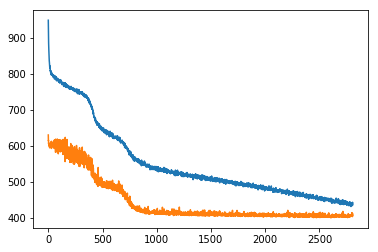

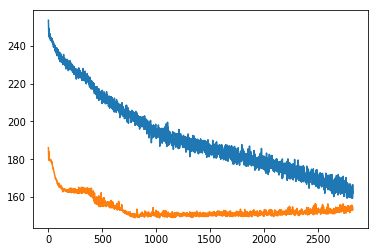

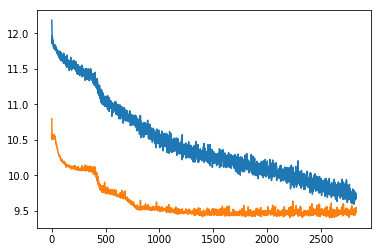

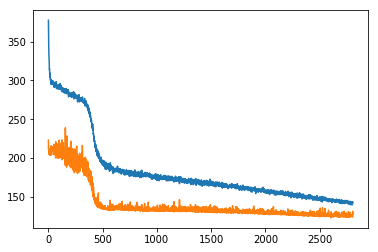

In [18]:
plt.figure()
plt.plot(history.history['loss'][20:])
plt.plot(history.history['val_loss'][20:])
plt.figure()
plt.plot(history.history['diff_pts_loss'])
plt.plot(history.history['val_diff_pts_loss'])
plt.figure()
plt.plot(history.history['diff_pts_mean_absolute_error'])
plt.plot(history.history['val_diff_pts_mean_absolute_error'])
plt.figure()
plt.plot(history.history['home_pts_loss'][20:])
plt.plot(history.history['val_home_pts_loss'][20:])